In [1]:
'''
  Import packages
'''

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import tqdm
import random
import numpy as np
import scipy as sp
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt 
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split

(10000, 1)


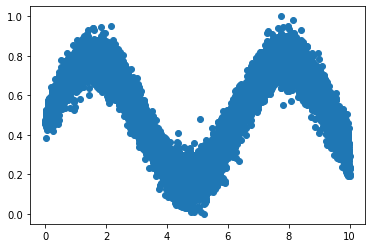

In [2]:
# Experiment 1: Learning a Simple Sinusoidal function with single-hidden layer neural network 

## dataset size
D = 10000
in_ch = 1
out_ch = 1

## parameters for noise distribution
mu = 0
sigma = 2

## generating data

def sigmoid(x, a=2):
  return 1 / (1 + np.exp(-a*x))


# input
x = np.random.rand(D, in_ch) * 10 

# groundtruth
y = np.expand_dims(np.sum(np.sin(x), axis=1)*10, axis=1); print(y.shape)

# Noisy GT
noisy_y = np.zeros_like(y)
# Generate Heteroscedastic Noise
# for i in range(D):
#   sigma = sigmoid(x)*2
#   noisy_y[i,:] = y[i,:] + np.random.normal(0, sigma)

noisy_y = y + np.random.normal(np.zeros(y.shape), sigmoid(x, a=2)*2)
# Min Max normalization

y_min = np.min(noisy_y)
y_max = np.max(noisy_y)

noisy_y = (noisy_y - y_min) / (y_max - y_min)


### train, test, validation split
X_train, X_test, y_train, y_test = train_test_split(x, noisy_y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=84)

plt.scatter(x[:, 0], noisy_y[:, 0])

In [3]:
class BayesNN(nn.Module):
  """
    Simple Aleatoric Bayesian neural network
    For each prediction, it outputs mean
    and standard deviation!
  """

  def __init__(self, in_ch, out_ch, hidden_size=100):
    super(BayesNN, self).__init__()
    self.layer1 = nn.Linear(in_ch, hidden_size)
    self.mu = nn.Linear(hidden_size, out_ch)
    self.sigma = nn.Linear(hidden_size, out_ch)

    self.sigmoid = nn.Sigmoid()
    self.relu = nn.ReLU()

  def forward(self, x):

    ## forward pass
    x = self.relu(self.layer1(x))
    mu = self.mu(x)
    sigma = self.sigma(x)

    return mu, self.sigmoid(sigma)

## Trainer class (implements standard training logic)


In [4]:
class Deterministic:
  """
      A general class for standard training/validation logic.
      Inherit this for different training/loss setup
  """

  def __init__(self, train_loader, val_loader, in_ch=in_ch, out_ch=out_ch, hidden_size=100, pretrained_model=None, validate_every=10, lr=0.1, early_stop_count=5):

    ## model
    self.net = BayesNN(in_ch, out_ch, hidden_size)

    ## train loader
    self.train_loader = train_loader

    ## validation loader
    self.val_loader = val_loader

    ## early stopping criterion
    self.early_stop_count = early_stop_count

    ## MSE loss for deterministic model
    self.mse = nn.MSELoss()
    self.validate_every = validate_every
    self.validation_scores = []

    ## Optimizer
    self.optim = optim.Adam(self.net.parameters(), lr)

    ## Schedular
    self.scheduler = optim.lr_scheduler.StepLR(self.optim, 5, 0.1)

    ## load if pretrained_model exists!
    if pretrained_model != None:
      self.net.load_state_dict(pretrained_model.state_dict())

  def loss_fn(self, batch_data):
    """
      Returns deterministc loss over the batch
    """

    batch_x = batch_data["x"]
    batch_y = batch_data["y"]
    batch_mu, batch_std = self.net(batch_x)

    return self.mse(batch_mu, batch_y)

  def train(self, num_epochs=400):
    """
      Training pipeline
    """

    print("----- Training Mode -----")
    best_model = None
    best_loss, early_stop = 99999, 0
    for self.epoch in range(num_epochs):
      
      epoch_loss = []
      for batch_data in self.train_loader:
        
        loss = self.loss_fn(batch_data)
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()
        epoch_loss.append(loss.item())

      if self.epoch % self.validate_every == 0:
        self.net.eval()
        val_score = self.validate()
        self.net.train()

        if val_score < best_loss:
          best_loss = val_score 
          best_model = self
          early_stop = 0
        else:
          early_stop += 1

        if early_stop > self.early_stop_count:
          break
      
      print('\rEpoch {}\tAverage Loss: {:.6f}'.format(self.epoch, np.mean(epoch_loss)), end="")

    return best_model

    # plt.plot(range(len(self.validation_scores)), self.validation_scores)
    # plt.show()

  def validate(self):
    """
      Get validation loss during training
    """

    # print("----- Validation Mode -----")
    val_losses = []

    for batch_data in self.val_loader:

      batch_x = batch_data["x"]
      batch_y = batch_data["y"]
      batch_mu, batch_std = self.net(batch_x) 

      loss = self.loss_fn(batch_data)
      val_losses.append(loss.item())
    return np.mean(val_losses)
    self.validation_scores.append(np.mean(val_losses))
    # print("Epoch %d: Avg Loss: %.4f"%(self.epoch, np.mean(val_losses)))

# Aleatoric Bayesian neural network:

### This block implements Negative log-likelihood loss also known as [loss attenuation](https://dl.acm.org/doi/10.5555/3295222.3295309)

$L_{NLL} = \frac{1}{N} \sum_{i = 1}^{N} \frac{1}{2} \left( \frac{({y_i} - {\mu_i})^2}{{\sigma_i}^2}  + \log{{\sigma_i}^2} \right)$

In [5]:
class LossAttenuation(Deterministic):
  """
    Inherits 'Deterministc' class and implemented 
    loss attenuation formulation proposed in 
    https://dl.acm.org/doi/10.5555/3295222.3295309
  """
  def __init__(self, train_loader, val_loader, in_ch=in_ch, out_ch=out_ch, hidden_size=100, pretrained_model=None, validate_every=10, lr=0.00001):
    super().__init__(train_loader, val_loader, in_ch, out_ch, hidden_size, pretrained_model, validate_every, lr)

  def loss_fn(self, batch_data):
    batch_x = batch_data["x"]
    batch_y = batch_data["y"]
    batch_mu, batch_std = self.net(batch_x)
    y, mu, var = batch_y.flatten(), batch_mu.flatten(), torch.square(batch_std.flatten())
    loss_att = torch.mean((y - mu)**2 / (2 * var) + (1/2) * torch.log(var))
    return loss_att



# fCal for Bayesian NN

## Here we implement fCal, a new technique to train calibrated neural network. 


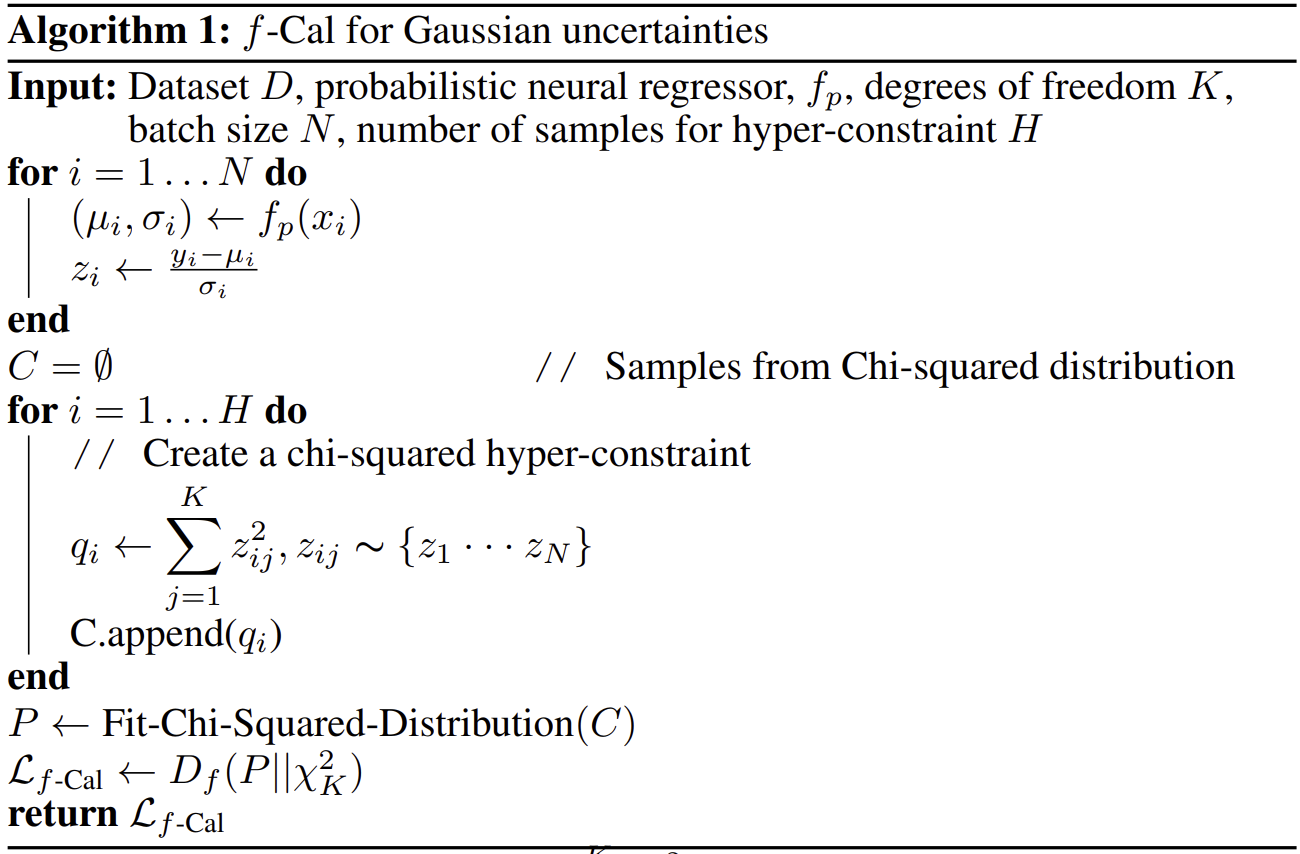

In [6]:

def batch_stats_loss_fn(batch_y, batch_mu, batch_std, K=50, loss_type="kld"):
    batch_size = batch_y.size()[0]
    chi_sq_samples = []
    for i in range(args.num_samples):
        idx = random.sample(range(0, batch_size), K)
        sample_y, sample_mu, sample_var = batch_y[idx], batch_mu[idx], torch.square(batch_std[idx])
        sample_q = ((sample_y - sample_mu)**2 / sample_var).sum()
        chi_sq_samples.append(sample_q)

    batch_stats = torch.stack(chi_sq_samples)
    emp_mu, emp_var = batch_stats.mean(), batch_stats.var()

    # Compute Distance b/w True and Predicted Induced Distribution
    if loss_type == "kld":
        approx_dist = torch.distributions.normal.Normal(emp_mu, torch.sqrt(emp_var))
        true_dist   = torch.distributions.normal.Normal(K*torch.ones([1]).cuda(), np.sqrt(2*K)*torch.ones([1]).cuda())

        loss = torch.distributions.kl.kl_divergence(approx_dist, true_dist).mean()

    elif loss_type == "w-dist":
        loss = ((emp_mu - K)**2 + emp_var + 2*K - 2*(emp_var*2*K)**0.5)

    return loss


class fCal(Deterministic):
  """
    Implements loss proposed in our method.
  
  """
  def __init__(self, train_loader, val_loader, in_ch=in_ch, out_ch=out_ch, hidden_size=100, pretrained_model=None,\
               validate_every=10, lr=0.00001, loss_type="kld", loss_weight=1e-2, num_samples=200, K=100):
    super().__init__(train_loader, val_loader, in_ch, out_ch, hidden_size, pretrained_model, validate_every, lr)

    ## degrees of freedom
    self.K = K

    ## loss type could be from ['w-dist', 'kld']
    self.loss_type = loss_type

    ## Scaling the loss
    self.loss_weight = loss_weight

    ## Number of chi-square samples to be generatied.
    self.H = num_samples



  def loss_fn(self, batch_data):
    """
      In this function, proposed f-Cal loss is implemented

    """
    batch_x = batch_data["x"]
    batch_y = batch_data["y"]
    batch_mu, batch_std = self.net(batch_x)
    y, mu, var = batch_y.flatten(), batch_mu.flatten(), torch.square(batch_std.flatten())
    det_loss = self.mse(batch_mu, batch_y)
    
    """
    The algorithm starts from here!
    """

    ## batchsize
    N = batch_y.size()[0]

    ## degrees of freedom
    K = self.K

    ## Number of hyperconstraints
    H = self.H

    ## Generating chi-square samples for degrees of freedom K
    ## Refer https://en.wikipedia.org/wiki/Chi-square_distribution
    chi_sq_samples = []
    for i in range(H):

      ## sample K indices at random
      idx = random.sample(range(0, N), K)

      ## Get groundtruth and predictions
      sample_y, sample_mu, sample_var = y[idx], mu[idx], var[idx]

      ## Chi-square is sum of standard normal random variables!
      sample_q = ((sample_y - sample_mu)**2 / sample_var).sum()

      ## collect chi-sq samples
      chi_sq_samples.append(sample_q)

    ## batch the chi-squared samples
    batch_stats = torch.stack(chi_sq_samples)

    ## Calculate statistics for the proposed distribution
    emp_mu, emp_var = batch_stats.mean(), batch_stats.var()

    ## Compute Distance b/w Target and Proposed Distribution

    ## if KLD loss!
    if self.loss_type == "kld":
      approx_dist = torch.distributions.normal.Normal(emp_mu, torch.sqrt(emp_var))
      true_dist   = torch.distributions.normal.Normal(self.K*torch.ones([1]).to(device), np.sqrt(2*self.K)*torch.ones([1]).to(device))

      fcal_loss = torch.distributions.kl.kl_divergence(approx_dist, true_dist).mean()

    elif self.loss_type == "w-dist":
      fcal_loss = ((emp_mu - self.K)**2 + emp_var + 2*self.K - 2*(emp_var*2*self.K)**0.5)

    ## f-Cal is weighted sum of Calibration and deterministic loss
    loss_att = torch.mean((y - mu)**2 / (2 * var) + (1/2) * torch.log(var))
    loss = fcal_loss*self.loss_weight + loss_att 
    return loss


In [7]:
class Dataset(data.Dataset):
  """
    For dataset loader
  """
  def __init__(self, X, y):
    super(Dataset, self).__init__()
    X = np.array(X)
    self.dataset_size = X.shape[0]
    self.X = X
    self.y = y

  def __getitem__(self, idx):
    data = {}
    data["x"] = torch.Tensor(self.X[idx])
    data["y"] = torch.Tensor(self.y[idx])

    return data
    
  def __len__(self):
    return self.dataset_size



In [8]:
## setting the pipeline
batch_size = 500
K = 100
num_epochs = 3000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_dataset = Dataset(X_train, y_train)
val_dataset = Dataset(X_val, y_val)
test_dataset = Dataset(X_test, y_test)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:

det = Deterministic(train_loader, val_loader, in_ch, out_ch, lr=0.001)
det.train(1000)

----- Training Mode -----
Epoch 529	Average Loss: 0.003940

In [10]:
lossatt = None
lossatt = LossAttenuation(train_loader, val_loader, in_ch, out_ch, lr=0.0001)
lossatt.train(num_epochs=1000)

----- Training Mode -----
Epoch 489	Average Loss: -1.908103

In [11]:
fcal_kld = None
fcal_kld = fCal(train_loader, val_loader, in_ch, out_ch, pretrained_model=lossatt.net, lr=0.0001, loss_type='kld', loss_weight=0.001)
fcal_kld.train(num_epochs=1000)

----- Training Mode -----
Epoch 79	Average Loss: -1.936551

In [12]:
fcal_wass = None
fcal_wass = fCal(train_loader, val_loader, in_ch, out_ch, pretrained_model=lossatt.net, lr=0.0001, loss_type='w-dist', loss_weight=0.0001)
fcal_wass.train(num_epochs=1000)

----- Training Mode -----
Epoch 189	Average Loss: -1.960375

In [13]:
def ECE(x, mu, std_dev, eps=0.05):
    """
      Calculate Expected calibration error(ECE).
    """
    emp_ac_ps = []
    ECE = []
    cal_curve_stats = []
    N = len(x); 
    k = 0;
    list_p = np.arange(0,1.0+eps, eps)
    for p in list_p:
        N_p = ((x-mu)/std_dev < norm.ppf(p)).sum(); #print(N_p.item())
        N_b = torch.logical_and((x-mu)/std_dev < norm.ppf(p), (x-mu)/std_dev > norm.ppf(k)).sum(); #print(N_b.item())
        emp_p = N_b.item() / N
        emp_ac_ps.append(N_p.item() / N)
        ECE.append((N_b.item() / N) * abs(emp_p - eps))
        k = p
    ece = np.sum(ECE) 
    return ece, list_p, emp_ac_ps

In [14]:
"""
    Evaluates models for different calibration
    metrics.
"""

class Evaluator:
  def __init__(self, test_loader, K=100):
    # self.net = net
    self.test_loader = test_loader
    self.mse = nn.MSELoss()
    self.K = K


  def test(self):
    """
        Testing net on test dataset
    
    """
    y, mu, std, y_true, std_true = [], [], [], [], []
    for idx, batch_data in enumerate(self.test_loader):
      batch_x = batch_data["x"].to(device)
      batch_y = batch_data["y"].to(device)
      batch_mu, batch_std = self.net(batch_x)

      mu.extend(batch_mu)
      std.extend(batch_std)
      y.extend(batch_y)

    return torch.stack(mu), torch.stack(std), torch.stack(y)

  def generate_chi_sq_samples(self, z, num_samples=10000):
    """
        Generate chi-squared samples from standard normal
        error residuals collected over the test dataset
    """
    chi_sq_samples, std_norms = [], []
    N = z.size()[0]
    for i in range(num_samples):
      idx = random.sample(range(0, N), self.K)
      sample_z = z[idx]
      sample_q = (sample_z**2).sum()
      chi_sq_samples.append(sample_q)
      std_norms.extend(sample_z)

    chi_sq_samples, std_norms = torch.stack(chi_sq_samples), torch.stack(std_norms); 
    return chi_sq_samples


  def eval(self, net):
    """
        Run evaluation and calculate ECE for 
        standard normal and chi-square!
    
    """
    self.net = net
    results = {}

    mu, std, y_true = self.test()
    mu, std, y_true = mu.flatten(), std.flatten(), y_true.flatten()
    # Calculate Deterministic Performance
    results["mse"] = self.mse(mu, y_true)

    # Calculate ECE(z) (i.e. for standard normal variables)
    z = (y_true - mu) / std
    results["ECE(z)"], list_p, emp_ac_ps = ECE(z, 0, 1)

    return "MSE: %.4f | ECE (z): %.4f   "%(results["mse"], results["ECE(z)"])

  def get_empirical_dist(self, net):
    self.net = net
    mu, std, y_true = self.test()
    z = (y_true - mu) / std
    z = z.detach()

    chi_sq_samples = self.generate_chi_sq_samples(z)

    return z, chi_sq_samples



In [15]:
eval = Evaluator(test_loader)

In [16]:
print("f-Cal (KLD)     : %s"%(eval.eval(fcal_kld.net)))
print("f-Cal (w-dist)  : %s"%(eval.eval(fcal_wass.net)))

f-Cal (KLD)     : MSE: 0.0169 | ECE (z): 0.0077   
f-Cal (w-dist)  : MSE: 0.0151 | ECE (z): 0.0069   


In [17]:
z_kld, chi_sq_kld = eval.get_empirical_dist(net=fcal_kld.net)
z_wass, chi_sq_wass = eval.get_empirical_dist(net=fcal_wass.net)

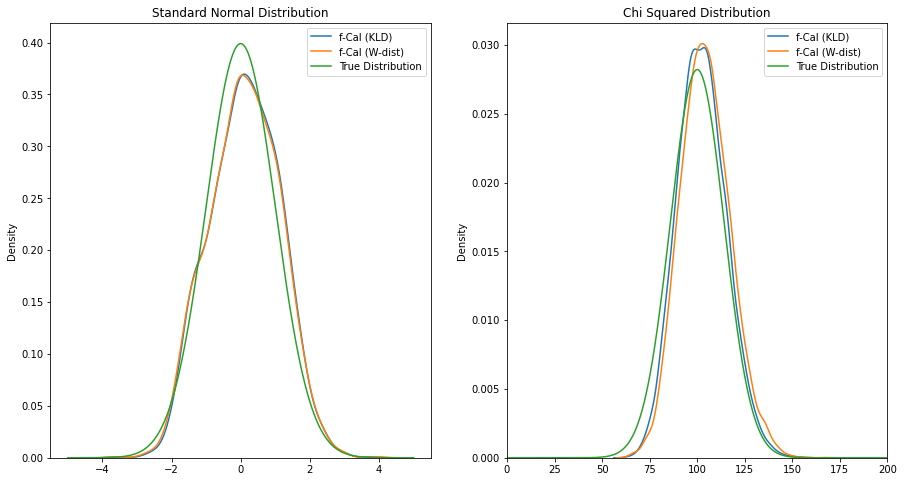

In [18]:
import warnings
warnings.filterwarnings('ignore')


plt.rcParams['figure.figsize'] = (15, 8)
fig, ax = plt.subplots(1, 2)
sns.distplot(z_kld.numpy(), label="f-Cal (KLD)", hist=False, ax=ax[0])
sns.distplot(z_wass.numpy(), label="f-Cal (W-dist)", hist=False, ax=ax[0])
x = np.linspace(0 - 5*1, 0 + 5*1, 10000)
ax[0].plot(x, norm.pdf(x, 0, np.sqrt(1)), label="True Distribution")
ax[0].set_title("Standard Normal Distribution")
ax[0].legend()

sns.distplot(chi_sq_kld.numpy(), label="f-Cal (KLD)", hist=False, ax=ax[1])
sns.distplot(chi_sq_wass.numpy(), label="f-Cal (W-dist)", hist=False, ax=ax[1])
x = np.linspace(100 - 500*1, 100 + 500*1, 10000)
ax[1].plot(x, norm.pdf(x, 100, np.sqrt(200)), label="True Distribution")
ax[1].set_title("Chi Squared Distribution")
ax[1].set_xlim(0, 200)
ax[1].legend()